# Обучение модели

In [13]:
%reload_ext autoreload
%autoreload 2

from _shared import *

NOTEBOOK_ID = '3'
name = 'gama_ASH_1_AS'  # GAMA + Asynchronous Successive Halving Algorithm + 1 + Andrey Sovtsov 

# Отключаем печать некоторых предупреждений
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
import importlib.util
import sys

import dill
import pandas as pd

import uai.data
import uai.models

In [8]:
df = pd.read_csv(ROOT_PATH / 'data/processed/data_for_model_1.csv')
df.head(3)

,id,age,dose,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,...,institution_id_22,institution_id_23,institution_id_24,institution_id_25,institution_id_26,institution_id_27,institution_id_28,institution_id_29,institution_id_30,institution_id_31
0,140361892057136,57,7.5,3.11,1,0,0,13.0,3.32,1,...,0,0,0,0,0,0,0,0,0,0
1,140361892057136,57,7.5,3.32,1,0,0,15.0,2.01,2,...,0,0,0,0,0,0,0,0,0,0
2,140361892057264,50,5.0,2.01,0,1,0,26.0,2.75,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Делим исходные данные на тренировочную и тестовую выборки

X_train, X_test, y_train, y_test = uai.data.custom_train_test_split(df, RANDOM_SEED)

In [10]:
# Загружаем еще не обученный пайплайн, существующий пока в виде кода на Питоне

spec = importlib.util.spec_from_file_location(
    name,
    ROOT_PATH / f'models/{name}.py'
)
module = importlib.util.module_from_spec(spec)
sys.modules[name] = module
spec.loader.exec_module(module)
pipe = module.pipeline
pipe

Pipeline(steps=[('ord-enc', OrdinalEncoder(cols=[], drop_invariant=True)),
                ('oh-enc', OneHotEncoder(cols=[])),
                ('target_enc', TargetEncoder(cols=[])),
                ('imputation', SimpleImputer(strategy='median')),
                ('1',
                 FeatureAgglomeration(affinity='manhattan', linkage='average')),
                ('0',
                 KNeighborsRegressor(n_neighbors=93, p=1, weights='distance'))])

Следующий код извлекает пайплайн из файла, экпортированного из TPOT в ноутбуке 2-create_model+TPOT

In [14]:
import importlib.util
import sys
from pathlib import Path
import re

name = 'TPOT_20gen_20populaton'  
pipeline_path = ROOT_PATH / f'models/{name}.py'


with open(pipeline_path, 'r') as file:
    file_content = file.read()

# извлечение только импортов и pipeline
imports_and_pipeline = re.findall(r'^(import .+|from .+|exported_pipeline = .+)$', file_content, re.MULTILINE)

code_to_execute = "\n".join(imports_and_pipeline)

module = importlib.util.module_from_spec(importlib.util.spec_from_loader(name, loader=None))

exec(code_to_execute, module.__dict__)

pipe = module.exported_pipeline
pipe

In [16]:
# Обучение пайплайна 

pipe.fit(X_train, y_train)

### Прогноз и расчет точности на полном наборе данных
# X_test = df.drop(columns=features2remove, axis=1)
# y_test = df['dose']

# Предсказание
predictions = pipe.predict(X_test)
rpredictions = [round(x, 3) for x in predictions]  # округление до точности исходных данных

scores = uai.models.calculate_metrics(rpredictions, y_test)
uai.models.print_metrics(scores)

Средняя абсолютная ошибка (MAE):                         0.61
Среднеквадратичная ошибка (MSE):                         0.86
Коэффициент детерминации (R^2):                          0.65
Средняя абсолютная процентная ошибка (MAPE):            20.99%
Доля предсказаний с отклонением не более 0,5 мг:        58.22%


Лучшие значения из экспериментов Андрея Совцова (просто для сравнения):
```
Средняя абсолютная ошибка (MAE):                         0.36
Среднеквадратичная ошибка (MSE):                         0.66
Коэффициент детерминации (R^2):                          0.73
Средняя абсолютная процентная ошибка (MAPE):            13.32%
Доля предсказаний с отклонением не более 0,5 мг:        72.60%
```

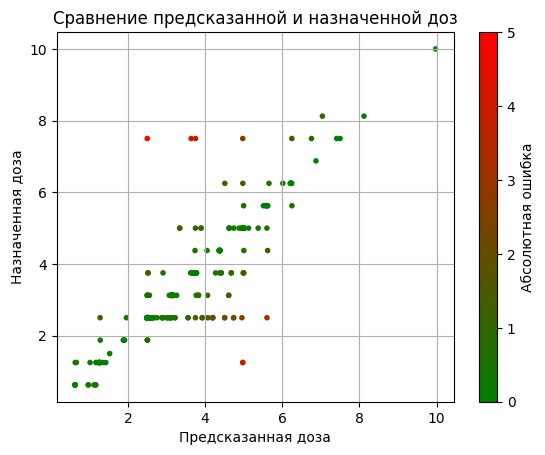

In [7]:
uai.models.plot_predictions(rpredictions, y_test)

In [17]:
# Сохраняем обученную модель в файл

fname = ROOT_PATH / f'models/{name}.dill'
with open(fname, 'wb') as f:
    dill.dump(pipe, f, recurse=True)

In [9]:
# Если ничего не напечаталось - то не дошли сюда, и где-то в ноутбуке ошибка
import datetime as dt
print('Ноутбук завершен:', dt.datetime.now())

Ноутбук завершен: 2023-11-05 03:04:41.459216
